In [2]:
%matplotlib inline

In [20]:
import cv2
import os
import math
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten,MaxPooling2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from tensorflow.keras.optimizers import Adam,SGD
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


In [4]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig('' + '_plot.png')
    pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # define model
    model = define_model()
    # fit model
    history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY), verbose=0)
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)

In [5]:
IMAGE_WIDTH=256
IMAGE_HEIGHT=256

In [6]:
#Load all patients 
my_data = pd.read_csv('../data/Five_Frames_Per_patient.csv')
patients_data=pd.read_csv('../data/videos_data.csv')
data_array = my_data.to_numpy()
patients_array=patients_data["FileName"].to_numpy()
images_path = '../data/Five_Frames_Per_patient/'
no_of_test_patients=math.floor(patients_array.size*0.2) 
images_data = []
models = []

df=my_data
data_array=df.to_numpy()
for i in data_array:
    img = cv2.imread(images_path + i[0] + '.' + i[2])
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
    img_2d = img.reshape(IMAGE_WIDTH ,IMAGE_HEIGHT,3)
    images_data.append(img_2d)

X=np.asarray(images_data)
y = np.asarray(my_data['Label'])

In [7]:
#Label encode classes to numbers
number = preprocessing.LabelEncoder()
y=number.fit_transform(y)
#One-hot Encode y
y=to_categorical(y,3)

In [8]:
testPatient_indexes= [1,2,15,16,21,22,
                      33,34,42,43,52,53,63,
                      92,95,96,99,101,102,105,110]


In [9]:
#getting frame indexes of each patient
frames_index=[]
for i in testPatient_indexes:
  j=i*5
  z=j+5
  while j<z:
    frames_index.append(j)
    j+=1
print(frames_index)

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 315, 316, 317, 318, 319, 460, 461, 462, 463, 464, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 495, 496, 497, 498, 499, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 525, 526, 527, 528, 529, 550, 551, 552, 553, 554]


In [10]:
# Adding the frames to X_test
X_test=np.take(X,frames_index,axis=0)
y_test=np.take(y,frames_index,axis=0)
# Removing the frames from X_train
X_train=np.delete(X,frames_index,axis=0)
y_train=np.delete(y,frames_index,axis=0)

# Scale the pixels
X_train=X_train/255.0
X_test=X_test/255.0

In [11]:
# initialize the training data augmentation object
MODEL_PATH=os.path.join('', "Conv2d-Better")

trainAug = ImageDataGenerator(
    rotation_range=10,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

mcp_save = ModelCheckpoint(
    MODEL_PATH,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [12]:
BATCH_SIZE=16
EPOCHS=20
#LR=0.00008
opt = SGD()
# Define callbacks
earlyStopping = EarlyStopping(
    monitor='loss',
    patience=20,
    verbose=1,
    mode='min',
    restore_best_weights=True
)


reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=7,
    verbose=1,
    min_delta=1e-4,
    mode='min'
)

In [13]:
print('X_train: '+str(X_train.shape))
print('y_train: '+str(y_train.shape))
print('X_test: '+ str(X_test.shape))
print('y_test: '+ str(y_test.shape))

X_train: (505, 256, 256, 3)
y_train: (505, 3)
X_test: (105, 256, 256, 3)
y_test: (105, 3)


In [67]:
drop=0.00
kernel=(2,2)
# Create model
model = Sequential()

model.add(Conv2D(16, kernel_size=kernel, activation='relu', 
                 kernel_initializer='he_uniform', padding='same', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))

model.add(Conv2D(16, kernel_size=kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(drop))

model.add(Conv2D(32, kernel_size=kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(32, kernel_size=kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(drop))

model.add(Conv2D(64, kernel_size=kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, kernel_size=kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(drop))

model.add(Conv2D(126, kernel_size=kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(126, kernel_size=kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(drop))

model.add(Conv2D(256, kernel_size=kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(256, kernel_size=kernel, activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(drop))


#Flatten results
model.add(Flatten())

#Hidden layers of 512 neurons
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))


In [68]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [69]:
history=model.fit(
    trainAug.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
)

Epoch 1/20
31/31 [==============================] - 8s 253ms/step - loss: 1.0632 - accuracy: 0.5297 - val_loss: 0.7499 - val_accuracy: 0.7238

Epoch 00001: val_accuracy did not improve from 0.86667
Epoch 2/20
31/31 [==============================] - 8s 246ms/step - loss: 0.8497 - accuracy: 0.6483 - val_loss: 0.8207 - val_accuracy: 0.5238

Epoch 00002: val_accuracy did not improve from 0.86667
Epoch 3/20
31/31 [==============================] - 7s 236ms/step - loss: 0.7560 - accuracy: 0.6933 - val_loss: 0.6627 - val_accuracy: 0.7143

Epoch 00003: val_accuracy did not improve from 0.86667
Epoch 4/20
31/31 [==============================] - 8s 260ms/step - loss: 0.7155 - accuracy: 0.7198 - val_loss: 0.6545 - val_accuracy: 0.7048

Epoch 00004: val_accuracy did not improve from 0.86667
Epoch 5/20
31/31 [==============================] - 7s 236ms/step - loss: 0.6629 - accuracy: 0.7362 - val_loss: 0.5205 - val_accuracy: 0.7905

Epoch 00005: val_accuracy did not improve from 0.86667
Epoch 6/20

Train: 0.857, Test: 0.781


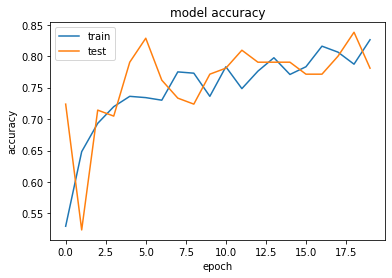

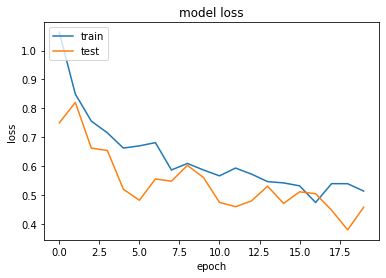

In [70]:
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'],
           loc='upper left')
plt.show()

Train: 0.826, Test: 0.867


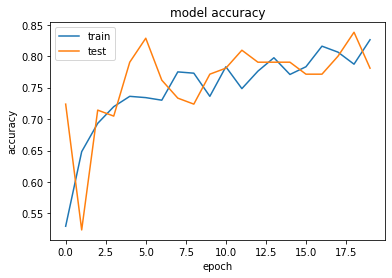

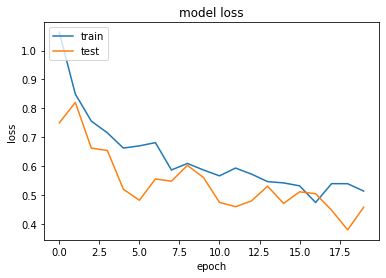

In [74]:
best_model= load_model("best_model")
model=best_model
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'],
           loc='upper left')
plt.show()

In [76]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 256, 256, 16)      208       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 256, 256, 16)      1040      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 128, 128, 32)      2080      
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 128, 128, 32)      4128      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 64, 64, 64)       